In [3]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms

In [4]:
# Loading small data from local folder

master_path = 'c:/Users/user/Downloads/2012-09-11/2012-09-11'

# Transform Settings - Do not use RandomResizedCrop
transform = transforms.Compose([transforms.Resize((224,224)), 
                                transforms.ToTensor()])

# Load data from Google Drive
dataset = torchvision.datasets.ImageFolder(master_path, transform=transform)

# Prepare Dataloader
batch_size = 1 # want to load one by one, did not help even if I change this
num_workers = 1
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

print("Done")

Done


IndexError: index 1 is out of bounds for axis 0 with size 1

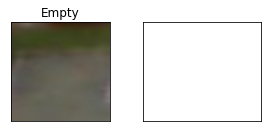

In [4]:
# Verification Step - obtain one batch of images
import matplotlib.pyplot as plt

dataiter = iter(data_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

classes = ['Empty', 'Occupied']

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [5]:
# Simple splitting

import numpy as np
from sklearn.model_selection import train_test_split

small_train, small_test = train_test_split(dataset, test_size=0.33, random_state=42)
print(len(small_train), len(small_test))
print(small_train)

2392 1179
[(tensor([[[0.3608, 0.3608, 0.3608,  ..., 0.1765, 0.1765, 0.1765],
         [0.3608, 0.3608, 0.3608,  ..., 0.1765, 0.1765, 0.1765],
         [0.3608, 0.3608, 0.3608,  ..., 0.1765, 0.1765, 0.1765],
         ...,
         [0.4353, 0.4353, 0.4353,  ..., 0.4196, 0.4196, 0.4196],
         [0.4353, 0.4353, 0.4353,  ..., 0.4196, 0.4196, 0.4196],
         [0.4353, 0.4353, 0.4353,  ..., 0.4196, 0.4196, 0.4196]],

        [[0.3843, 0.3843, 0.3843,  ..., 0.1882, 0.1882, 0.1882],
         [0.3843, 0.3843, 0.3843,  ..., 0.1882, 0.1882, 0.1882],
         [0.3843, 0.3843, 0.3843,  ..., 0.1882, 0.1882, 0.1882],
         ...,
         [0.4353, 0.4353, 0.4353,  ..., 0.4196, 0.4196, 0.4196],
         [0.4353, 0.4353, 0.4353,  ..., 0.4196, 0.4196, 0.4196],
         [0.4353, 0.4353, 0.4353,  ..., 0.4196, 0.4196, 0.4196]],

        [[0.2039, 0.2039, 0.2039,  ..., 0.1451, 0.1451, 0.1451],
         [0.2039, 0.2039, 0.2039,  ..., 0.1451, 0.1451, 0.1451],
         [0.2039, 0.2039, 0.2039,  ..., 0.1451

In [19]:
# Did not use this block for now
###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def normalize_label(labels):
    """
    Given a tensor containing 2 possible values, normalize this to 0/1

    Args:
        labels: a 1D tensor containing two possible scalar values
    Returns:
        A tensor normalize to 0/1 value
    """
    max_val = torch.max(labels)
    min_val = torch.min(labels)
    norm_labels = torch.true_divide((labels - min_val),(max_val - min_val))
    return norm_labels

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

     Args:
         net: PyTorch neural network object
         loader: PyTorch data loader for the validation set
         criterion: The loss function
     Returns:
         err: A scalar for the avg classification error over the validation set
         loss: A scalar for the average loss function over the validation set
     """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data
        labels = normalize_label(labels)  # Convert labels to 0/1
        outputs = net(inputs)
        loss = criterion(outputs, labels.float())
        corr = (outputs > 0.0).squeeze().long() != labels
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    return err, loss

###############################################################################
# Training Curve
def plot_training_curve(train_err, train_loss, val_err, val_loss):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    import matplotlib.pyplot as plt
    #train_err = np.loadtxt("{}_train_err.csv".format(path))
    #val_err = np.loadtxt("{}_val_err.csv".format(path))
    #train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    #val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

In [8]:
class SmallNet(nn.Module):
    def __init__(self):
        super(SmallNet, self).__init__()
        self.name = "small"
        self.conv = nn.Conv2d(3, 5, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(55*55*5, 1) #did not figure out why it is 484000 for now, but know that input image is 224x224

    def forward(self, x):
        x = self.pool(F.relu(self.conv(x)))
        x = self.pool(x)
        x = x.view(-1, 55*55*5)
        x = self.fc(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return x
    
print("Done")

Done


In [9]:
print("Parameters in small_net:")
small_net = SmallNet()
for param in small_net.parameters(): 
   print(param.shape)


Parameters in small_net:
torch.Size([5, 3, 3, 3])
torch.Size([5])
torch.Size([1, 15125])
torch.Size([1])


In [22]:
def train_net(net, train_loader, test_loader, learning_rate, num_epochs):

    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)

    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Binary Cross Entropy (BCE). In this case we
    # will use the BCEWithLogitsLoss which takes unnormalized output from
    # the neural network and scalar label.
    # Optimizer will be SGD with Momentum.
    
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_err = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_err = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    #start_time = time.time()
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data
            #labels = normalize_label(labels) # Convert labels to 0/1
            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize

            #print(inputs, inputs.shape)
            
            outputs = net(inputs)
            
            #print(outputs, outputs.shape)
            
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (outputs > 0.0).squeeze().long() != labels
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_err[epoch] = float(total_train_err) / total_epoch
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_err[epoch], val_loss[epoch] = evaluate(net, test_loader, criterion)
        print(("Epoch {}: Train err: {}, Train loss: {} |"+
               "Validation err: {}, Validation loss: {}").format(
                   epoch + 1,
                   train_err[epoch],
                   train_loss[epoch],
                   val_err[epoch],
                   val_loss[epoch]))
        
    return train_err, train_loss, val_err, val_loss

print('Done')

Done


In [11]:
# Prepare Dataloader of train and test set

batch_size = 32
num_workers = 1
train_loader = torch.utils.data.DataLoader(small_train, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(small_test, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)

print("Done")


Done


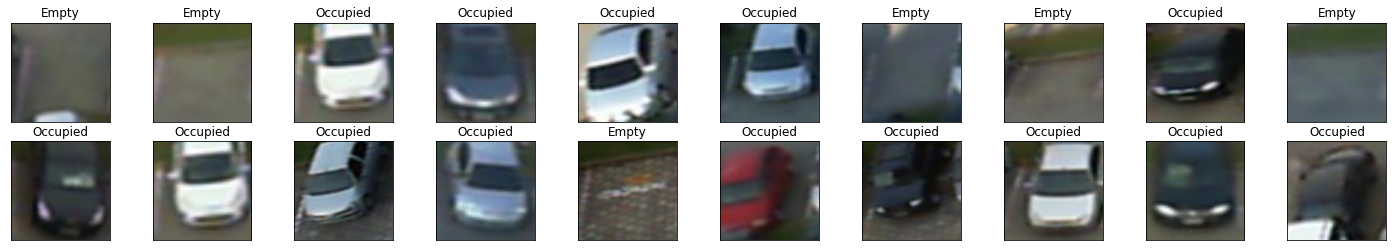

In [12]:
# Verification Step for train and test loader - obtain one batch of images fo
import matplotlib.pyplot as plt

dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

classes = ['Empty', 'Occupied']

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

In [23]:
small_net = SmallNet()

num_epochs = 7
train_err = np.zeros(num_epochs)
train_loss = np.zeros(num_epochs)
val_err = np.zeros(num_epochs)
val_loss = np.zeros(num_epochs)

train_err, train_loss, val_err, val_loss = train_net(small_net, train_loader, test_loader, learning_rate=0.01, num_epochs=num_epochs)

print("Done")

Epoch 1: Train err: 0.13879598662207357, Train loss: 0.3213406462222338 |Validation err: 0.06700593723494487, Validation loss: 0.12828652938274113
Epoch 2: Train err: 0.023829431438127092, Train loss: 0.07281788698087135 |Validation err: 0.013570822731128074, Validation loss: 0.050508806708495356
Epoch 3: Train err: 0.008779264214046822, Train loss: 0.032624894821395474 |Validation err: 0.005937234944868533, Validation loss: 0.03359532694181276
Epoch 4: Train err: 0.005434782608695652, Train loss: 0.020522992640423277 |Validation err: 0.01272264631043257, Validation loss: 0.04953211825340986
Epoch 5: Train err: 0.006270903010033445, Train loss: 0.01863632757992794 |Validation err: 0.005089058524173028, Validation loss: 0.020126265372980286
Epoch 6: Train err: 0.0016722408026755853, Train loss: 0.00958702844567597 |Validation err: 0.004240882103477523, Validation loss: 0.02109189977479243
Epoch 7: Train err: 0.0020903010033444815, Train loss: 0.009716026548994705 |Validation err: 0.0084

In [24]:
print(train_err, len(train_err))
print(val_err, len(val_err))

[0.13879599 0.02382943 0.00877926 0.00543478 0.0062709  0.00167224
 0.0020903 ] 7
[0.06700594 0.01357082 0.00593723 0.01272265 0.00508906 0.00424088
 0.00848176] 7


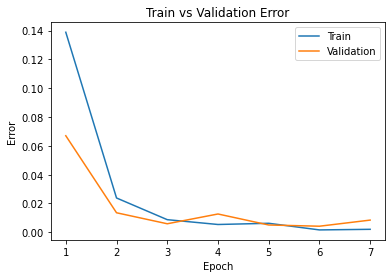

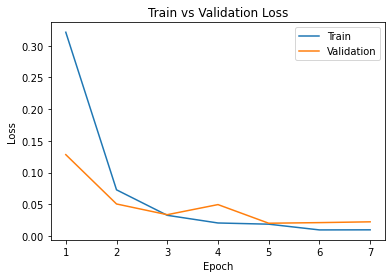

In [25]:
plot_training_curve(train_err, train_loss, val_err, val_loss)